In [1]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from cb_models import HHModel, NeuroDynModel

# **Ignore overflow warnings**
import numpy as np
np.seterr(all="ignore")

%matplotlib inline
%load_ext autoreload
%autoreload 2

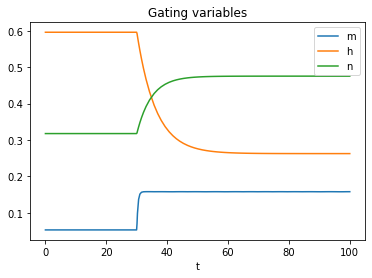

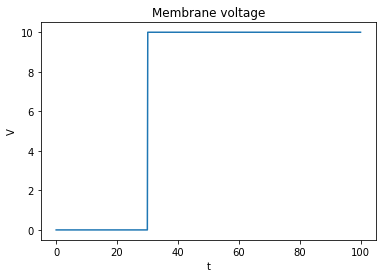

In [2]:
# Create a Hodgkin-Huxley neuron
hh_neuron = HHModel()

# Define voltage
V0 = 0 # initial voltage is 0mV
V1 = 10 # step change to 10mV

# Define membrane voltage as a function of time
tstart = 30 # apply the step at 30ms
Vclamp = lambda t: V0 * (t <= tstart) + V1 * (t > tstart)

# Initial state
x0 = [hh_neuron.m.inf(V0), hh_neuron.h.inf(V0), hh_neuron.n.inf(V0)] # set states to steady-state values

# Define simulation time range
T = 100
trange = (0, T)

sol = hh_neuron.vclamp(trange, x0, Vclamp)
m = sol.y[0]
h = sol.y[1]
n = sol.y[2]
V = Vclamp(sol.t)

# Plot gating variables as function of time
plt.figure()
plt.title("Gating variables")
plt.xlabel('t')
plt.plot(sol.t, m, label = 'm')
plt.plot(sol.t, h, label = 'h')
plt.plot(sol.t, n, label = 'n')
plt.legend()

plt.figure()
plt.title('Membrane voltage')
plt.xlabel('t')
plt.ylabel('V')
plt.plot(sol.t, V)
plt.show()


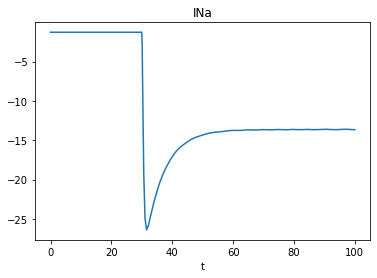

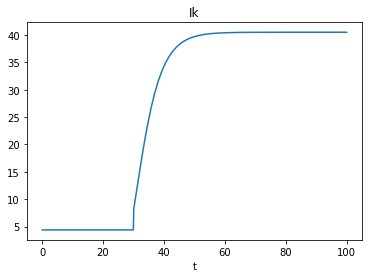

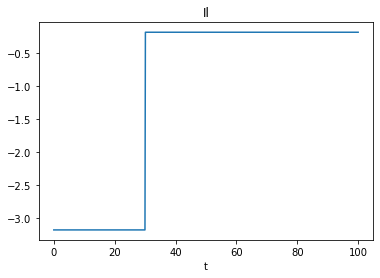

In [3]:
# Find the ionic currents
Ina = hh_neuron.Ina(V, m, h)
Ik = hh_neuron.Ik(V, n)
Il = hh_neuron.Il(V)

plt.figure()
plt.title('INa')
plt.xlabel('t')
plt.plot(sol.t, Ina, label = 'INa')
plt.figure()
plt.title('Ik')
plt.xlabel('t')
plt.plot(sol.t, Ik, label = 'IK')
plt.figure()
plt.title('Il')
plt.xlabel('t')
plt.plot(sol.t, Il, label = 'Il')
plt.show()

In [4]:
def run_vstep_potassium(voltage):

    hh_neuron = HHModel(gna = 0, gl = 0)

    # Define voltage
    V0 = 0
    V1 = V0 + voltage

    # Define membrane voltage as a function of time
    tstart = 0 # apply the step at 30ms
    Vclamp = lambda t: V0 * (t <= tstart) + V1 * (t > tstart)

    # Initial state
    x0 = [hh_neuron.m.inf(V0), hh_neuron.h.inf(V0), hh_neuron.n.inf(V0)] # set states to steady-state values

    # Define simulation time range
    T = 100
    trange = (0, T)
    
    sol = hh_neuron.vclamp(trange, x0, Vclamp)
    m = sol.y[0]
    h = sol.y[1]
    n = sol.y[2]
    V = Vclamp(sol.t)

    Ina = hh_neuron.Ina(V, m, h)
    Ik = hh_neuron.Ik(V, n)
    Il = hh_neuron.Il(V)
    
    result = {
        't': sol.t,
        'V': V,
        'I': Ik,
    }
    
    return result

def run_vstep_sodium(voltage):

    hh_neuron = HHModel(gk = 0, gl = 0)

    # Define voltage
    V0 = 0
    V1 = V0 + voltage

    # Define membrane voltage as a function of time
    tstart = 0 # apply the step at 30ms
    Vclamp = lambda t: V0 * (t <= tstart) + V1 * (t > tstart)

    # Initial state
    x0 = [hh_neuron.m.inf(V0), hh_neuron.h.inf(V0), hh_neuron.n.inf(V0)] # set states to steady-state values

    # Define simulation time range
    T = 25
    trange = (0, T)
    
    sol = hh_neuron.vclamp(trange, x0, Vclamp)
    m = sol.y[0]
    h = sol.y[1]
    n = sol.y[2]
    V = Vclamp(sol.t)

    Ina = hh_neuron.Ina(V, m, h)
    Ik = hh_neuron.Ik(V, n)
    Il = hh_neuron.Il(V)
    
    result = {
        't': sol.t,
        'V': V,
        'I': Ina,
    }
    
    return result

def get_conductance(I, E, E0):
    return I/(E-E0)

def compute_conductance(result, E0):
    currents = result['I']
    voltages = result['V']
    conductances = [I/(E-E0) for (I,E) in zip (currents, voltages)]
    return conductances
        
def get_conductance_results(result_list, E0):
    return [compute_conductance(result, E0) for result in result_list]

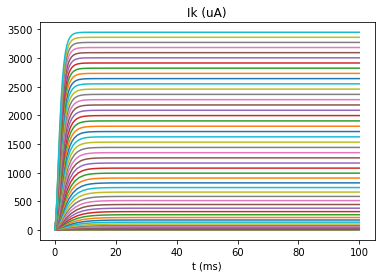

In [5]:
# run potassium experiment
voltages = np.linspace(0, 100, 50)
result_list = []
for voltage in voltages:
    result = run_vstep_potassium(voltage)
    result_list.append(result)
    
plt.figure()
plt.title('Ik (uA)')
plt.xlabel('t (ms)')
for result in result_list:
    plt.plot(result['t'], result['I'])
plt.show()

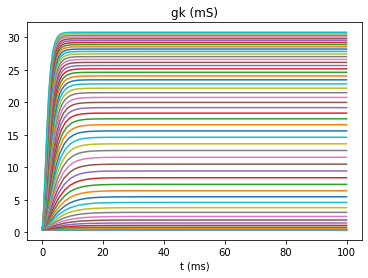

In [6]:
# evaluate potassium conductances
Ek=-12
conductance_results = get_conductance_results(result_list, Ek)

plt.figure()
plt.title('gk (mS)')
plt.xlabel('t (ms)')
for i, conductance in enumerate(conductance_results):
    plt.plot(result_list[i]['t'], conductance)
plt.show()

/Users/paolocd/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


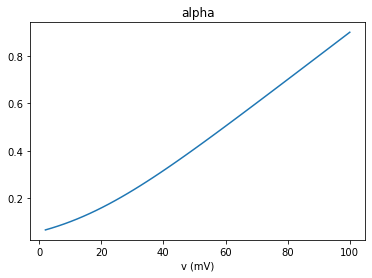

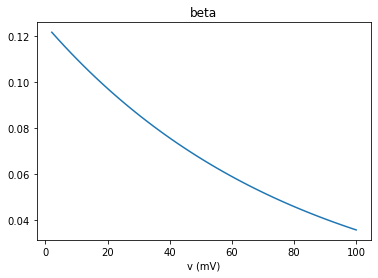

In [7]:
# get alpha beta for potassium channel
gk_max = 36

def potassium_g_equation(X, tau):
    g_inf, g_zero, t = X
    return (g_inf**(1/4)-(g_inf**(1/4)-g_zero**(1/4))*np.exp(-t/tau))**4

def fit_potassium_conductance(conductance, t):
    g_inf = conductance[-1]
    g_zero = conductance[0]
    g_inf_list = [g_inf for g in conductance]
    g_zero_list = [g_zero for g in conductance]
    popt, pcov = curve_fit(potassium_g_equation, (g_inf_list, g_zero_list, t), conductance)
    
#     plt.figure()
#     plt.plot(t, (g_inf**(1/4)-(g_inf**(1/4)-g_zero**(1/4))*np.exp(-t/popt[0]))**4)
#     plt.plot(t, conductance)
    
    return popt[0]

alpha_list = []
beta_list = []
v_list = []
for i, conductance in enumerate(conductance_results):
    voltage = result_list[i]['V'][-1]
    tau = fit_potassium_conductance(conductance, result_list[i]['t'])
    g_inf = conductance[-1]
    n_inf = (g_inf/gk_max)**(1/4)
    alpha = n_inf/tau
    beta = (1-n_inf)/tau
    
    alpha_list.append(alpha)
    beta_list.append(beta)
    v_list.append(voltage)
    
plt.figure()
plt.title('alpha')
plt.xlabel('v (mV)')
plt.plot(v_list[1:], alpha_list[1:])
plt.show()

plt.figure()
plt.title('beta')
plt.xlabel('v (mV)')
plt.plot(v_list[1:], beta_list[1:])
plt.show()

In [ ]:
# HH potassium parameters
alpha = hh_neuron.n.alpha(np.asarray(v_list))
beta = hh_neuron.n.beta(np.asarray(v_list))

plt.figure()
plt.title('alpha')
plt.xlabel('v (mV)')
plt.plot(v_list, alpha)
plt.show()

plt.figure()
plt.title('beta')
plt.xlabel('v (mV)')
plt.plot(v_list, beta)
plt.show()

In [ ]:
# run sodium experiment
voltages = np.linspace(0, 100, 10)
result_list = []
for voltage in voltages:
    result = run_vstep_sodium(voltage)
    result_list.append(result)
    
plt.figure()
plt.title('Ina (uA)')
plt.xlabel('t (ms)')
for result in result_list:
    plt.plot(result['t'], result['I'])
plt.show()

Ena=120
conductance_results = get_conductance_results(result_list, Ena)

plt.figure()
plt.title('gNa (mS)')
plt.xlabel('t (ms)')
for i, conductance in enumerate(conductance_results):
    plt.plot(result_list[i]['t'], conductance)
plt.show()

In [ ]:
# get alpha beta for sodium channel
gna_max = 36
     
alpha_list_m = []
beta_list_m = []
alpha_list_h = []
beta_list_h = []
v_list = []

def sodium_g_equation(X, tau_m, tau_h):
    gna_max, m_inf_list, h_zero_list, t = X
    return (gna_max*m_inf_list**3*h_zero_list*(1-np.exp(-t/tau_m))**3*np.exp(-t/tau_h))

def fit_sodium_conductance(conductance, t, gna_max, m_inf, h_zero):
    gna_max_list = [gna_max for g in conductance]
    m_inf_list = [m_inf for g in conductance]
    h_zero_list = [h_zero for g in conductance]
    popt, pcov = curve_fit(sodium_g_equation, (gna_max_list, m_inf_list, h_zero_list, t), conductance)
    return popt
            
for i, conductance in enumerate(conductance_results):
    voltage = result_list[i]['V'][-1]
    
    # I am not sure how to calculate these parameters
    m_inf = max(conductance) 
    h_zero = conductance[0] 
    h_inf = conductance[-1] 
            
    tau_m, tau_h = fit_sodium_conductance(conductance, result_list[i]['t'], gna_max, m_inf, h_zero)
  
    alpha_m = m_inf/tau_m
    beta_m = (1-m_inf)/tau_m
    alpha_h = h_inf/tau_h
    beta_h = (1-h_inf)/tau_h
    
    alpha_list_m.append(alpha_m)
    beta_list_m.append(beta_m)
    alpha_list_h.append(alpha_h)
    beta_list_h.append(beta_h)
    v_list.append(voltage)
    
plt.figure()
plt.title('alpha_m')
plt.xlabel('v (mV)')
plt.plot(v_list[1:], alpha_list_m[1:])
plt.show()

plt.figure()
plt.title('beta_m')
plt.xlabel('v (mV)')
plt.plot(v_list[1:], beta_list_m[1:])
plt.show()

In [ ]:
# HH sodium parameters
alpha_m = hh_neuron.m.alpha(np.asarray(v_list))
beta_m = hh_neuron.m.beta(np.asarray(v_list))

plt.figure()
plt.title('alpha')
plt.xlabel('v (mV)')
plt.plot(v_list, alpha_m)
plt.show()

plt.figure()
plt.title('beta')
plt.xlabel('v (mV)')
plt.plot(v_list, beta_m)
plt.show()